In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from itertools import combinations
from IPython.display import display

### Settings (Edit Each Run)

In [2]:
# The drug to study
agents = ["Trastuzumab", "Pertuzumab", "Paclitaxel", "Capecitabine"]
# Include anything with the agent name
combination_therapy = [True, True, True, True]
# The gene to examine
gene = "ERBB2"
# cancerTypeDetailed, cancerType, or oncotreeLevel2
analysis_type = 'cancerType'
# The cancer type
ctype = "Breast Cancer"
# Modifier to the date (how many days earlier the sequencing can be from start of treatment)
modifier = 20
# Modifier to the date (how many days after still counts for death)
modifier_after = 50

config = "../global_config_bash_4.rc"
colors = ["steelblue", "sandybrown", "coral"]

### Get files from config

In [3]:
## Parse config ##

with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [4]:
## Fill dataframes ##

# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# FileA in the manifest directory
manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

# CDSI data
progression = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_progression.txt', sep = '\t')
sequencing = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_specimen_surgery.txt', sep = '\t')
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_timeline_follow_up.txt', sep = '\t')
treatment_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_treatment.txt', sep = '\t')

### Clean Up and Prepare Dataframes

In [5]:
## Get data from oncotree API ##

url = 'https://oncotree.mskcc.org/api/tumorTypes/tree'
headers = {'Accept': 'application/json'}

response = requests.get(url, headers=headers)

def parse_tree(data):
    if not isinstance(data, dict):
        return data
    
    parsed_data = {}
    for key, value in data.items():
        if isinstance(value, dict):
            parsed_data[key] = parse_tree(value)
        elif isinstance(value, list):
            parsed_data[key] = [parse_tree(item) for item in value]
        else:
            parsed_data[key] = value
    
    return parsed_data

parsed_data = parse_tree(response.json())

# Matches oncotree code to name of cancer
oncotree_dict = {}

def dfs_oncotree(node):
    codes = [node['code']]
    # Recursively traverse children
    for child in node['children'] :
        codes.extend(dfs_oncotree(node['children'][child]))
    return codes

for tissue in parsed_data['TISSUE']['children'] :
    for specific in parsed_data['TISSUE']['children'][tissue]['children'] :
        oncotree_dict[parsed_data['TISSUE']['children'][tissue]['children'][specific]['name']] = set(dfs_oncotree(parsed_data['TISSUE']['children'][tissue]['children'][specific]))


In [6]:
## Merge echo dataframe ##

echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType', 'mutationCount', 'fractionAltered','osStatus', 'osMonths', 'deIDAge', 'stageHighest']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')

echo['oncotreeLevel2'] = ""
for i, row in echo.iterrows() :
        for key in oncotree_dict :
            if row['oncotreeCode'] in oncotree_dict[key] :
                echo.loc[i, 'oncotreeLevel2'] = key


In [7]:
## Get a per sample dataframe ##

# Restrict to the cancer type 
echo = echo[echo[analysis_type] == ctype]

per_sample = pd.DataFrame(echo['tumorSampleId'].unique(), columns = ['sampleId'])
per_sample['amp'] = False
per_sample['ecDNA'] = False
per_sample['patientId'] = ""
per_sample['cn'] = 2

# Dict for indexes in dataframe
per_sample_idx = {}
for i, row in per_sample.iterrows() :
    per_sample_idx[row['sampleId']] = i
    per_sample.loc[i, 'patientId'] = row['sampleId'].split('-')[0] + '-' + row['sampleId'].split('-')[1]

for i, row in echo.iterrows() :
    if row['gene'] == gene :
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'amp'] = True
        if row['ecDNA_status'] == 'ecDNA' :
            per_sample.loc[per_sample_idx[row['tumorSampleId']], 'ecDNA'] = True
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'cn'] = row['cn']

# Combined status
per_sample['combined'] = "No ecDNA & No Amp"
for i, row in per_sample.iterrows() :
    if row['ecDNA'] :
        per_sample.loc[i, 'combined'] =  "ecDNA & Amp"       
    elif row['amp'] :
        per_sample.loc[i, 'combined'] =  "No ecDNA & Amp"       

In [8]:
## Fill in dicts from CDSI data ##

# death dates if applicable
death_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Patient Deceased" :
        death_dict[row['PATIENT_ID']] = row['START_DATE']

# Last contact dates if applicable
last_contact_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

# Sequencing (sample acquisition) dates
sequencing_dict = {}
for i, row in sequencing.iterrows() :
    sequencing_dict[row['SAMPLE_ID']] = row['START_DATE']

# only the ones above threshold
progression_positive = progression[progression['PROGRESSION'] == 'Yes']
# Progression dates for each patient (list for each)
progression_by_patient = {}
for i, row in progression_positive.iterrows() :
    if row['PATIENT_ID'] in progression_by_patient :
        progression_by_patient[row['PATIENT_ID']].append(row['START_DATE'])
    else :
        progression_by_patient[row['PATIENT_ID']] = [row['START_DATE']]

In [9]:
## Make list of dictionaries for treatment. Contains patient time info for each drug ##

treatment_dict_arr = []
for agent_num, agent in enumerate(agents) :
    # Dict to add
    treatment_dict = {}
    for i, row in treatment_data.iterrows() :
        if combination_therapy[agent_num] :
            if agent in row['AGENT'] :
                if row['PATIENT_ID'] in treatment_dict :
                    treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
                else :
                    treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]
        else :
            if row['AGENT'] == agent :
                if row['PATIENT_ID'] in treatment_dict :
                    treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
                else :
                    treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]
    treatment_dict_arr.append(treatment_dict)

In [10]:
## Fill in time in sample wise dataframe ##

for agent_num, agent in enumerate(agents) :
    per_sample[f'progressedOrDeceased_{agent}'] = False
    per_sample[f'deceased_{agent}'] = False
    per_sample[f'pfs_{agent}'] = np.nan
    per_sample[f'os_{agent}'] = np.nan
    
    # Iterate all samples
    for i, row in per_sample.iterrows() :
        if row['sampleId'] in sequencing_dict :
            seq_time = sequencing_dict[row['sampleId']]
        
            # Iterate all treatment dates for that sample
            if row['patientId'] in treatment_dict_arr[agent_num] :
                for date_pair in treatment_dict_arr[agent_num][row['patientId']] :
        
                    # If we find a date pair that covers the sequence time
                    if date_pair[0] - modifier < seq_time and (date_pair[1] == np.nan or date_pair[1] > seq_time) :
                        if date_pair[1] == np.nan :
                            end_date = 1000000
                            os_date = 1000000
                        else :
                            end_date = date_pair[1]
                            os_date = date_pair[1]
        
                        # Go through progression dates
                        if row['patientId'] in progression_by_patient :
                            for prog_date in progression_by_patient[row['patientId']] :
                                if prog_date > date_pair[0] and prog_date < date_pair[1] :
                                    per_sample.loc[i, f'progressedOrDeceased_{agent}'] = True
                                    end_date = min(end_date, prog_date)
        
                        # Check if patient has died
                        if row['patientId'] in death_dict :
                            if death_dict[row['patientId']] <= end_date + modifier_after :
                                end_date = min(end_date, death_dict[row['patientId']])
                                per_sample.loc[i, f'progressedOrDeceased_{agent}'] = True
                                per_sample.loc[i, f"deceased_{agent}"] = True
                                os_date = death_dict[row['patientId']]
        
                        # Add last contact possibility
                        if row['patientId'] in last_contact_dict :
                            end_date = min(end_date, last_contact_dict[row['patientId']])
                            os_date = min(os_date, last_contact_dict[row['patientId']])
    
                        if end_date != 1000000 :
                            per_sample.loc[i, f'pfs_{agent}'] = end_date - date_pair[0] 
                        
                        if os_date != 1000000 :
                            per_sample.loc[i, f'os_{agent}'] = os_date - date_pair[0] 
        else :
            print(f"{row['sampleId']} Sequencing Date Not Found")

P-0000131-T01-IM3 Sequencing Date Not Found
P-0000281-T02-IM3 Sequencing Date Not Found
P-0000358-T01-IM3 Sequencing Date Not Found
P-0001818-T01-IM3 Sequencing Date Not Found
P-0002023-T01-IM3 Sequencing Date Not Found
P-0002036-T01-IM3 Sequencing Date Not Found
P-0002447-T01-IM3 Sequencing Date Not Found
P-0002567-T01-IM3 Sequencing Date Not Found
P-0002995-T03-IM6 Sequencing Date Not Found
P-0002997-T01-IM3 Sequencing Date Not Found
P-0003198-T02-IM5 Sequencing Date Not Found
P-0003198-T03-IM5 Sequencing Date Not Found
P-0003198-T04-IM6 Sequencing Date Not Found
P-0003286-T01-IM5 Sequencing Date Not Found
P-0003481-T01-IM5 Sequencing Date Not Found
P-0003509-T01-IM5 Sequencing Date Not Found
P-0003647-T01-IM5 Sequencing Date Not Found
P-0003882-T02-IM6 Sequencing Date Not Found
P-0004180-T01-IM5 Sequencing Date Not Found
P-0004317-T01-IM5 Sequencing Date Not Found
P-0004455-T01-IM5 Sequencing Date Not Found
P-0004540-T01-IM5 Sequencing Date Not Found
P-0004980-T01-IM5 Sequencing Dat

### Results

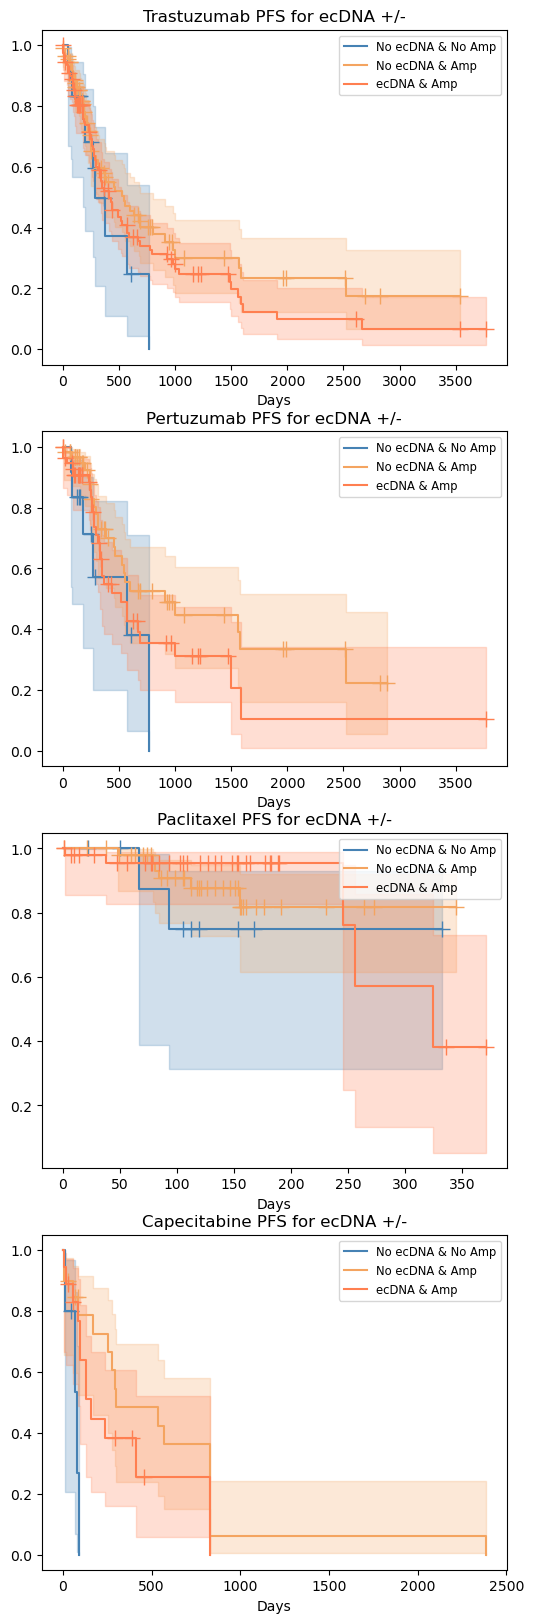

In [11]:
## Progression free survival for all treatments ##

# Ignore all warnings
warnings.filterwarnings('ignore')

fig, axs = plt.subplots(len(agents), 1, figsize = (6, 5 * len(agents)))
axs = axs.flatten()

for agent_num, agent in enumerate(agents) :
    per_sample_for_km = per_sample.dropna(subset = [f"pfs_{agent}"])
    
    kmf = KaplanMeierFitter()
    for num, status in enumerate(['No ecDNA & No Amp', 'No ecDNA & Amp', 'ecDNA & Amp']):
        subset = per_sample_for_km[per_sample_for_km['combined'] == status]
        kmf.fit(subset[f'pfs_{agent}'], event_observed=(subset[f'progressedOrDeceased_{agent}'] == True))
        # labels
        kmf.plot(show_censors=True, ci_show=True, label=f'{status}', ax = axs[agent_num], color = colors[num])

    axs[agent_num].legend(loc='upper right', fontsize='small')

    axs[agent_num].set_title(f'{agent} PFS for ecDNA +/-')
    axs[agent_num].set_xlabel("Days")
    

In [12]:
## P-value matrix ##

for agent in agents :
    per_sample_for_km = per_sample.dropna(subset = [f"pfs_{agent}"])

    kmf = KaplanMeierFitter()
    kmf2 = KaplanMeierFitter()
    
    statuses = per_sample_for_km['combined'].unique()
    pairwise_tests = {}
    
    for group1, group2 in combinations(statuses, 2) :
        group1_data = per_sample_for_km[per_sample_for_km['combined'] == group1]
        group2_data = per_sample_for_km[per_sample_for_km['combined'] == group2]
    
        # Fit KM curves
        kmf.fit(group1_data[f'pfs_{agent}'], event_observed=(group1_data['combined'] == 1))
        kmf2.fit(group2_data[f'pfs_{agent}'], event_observed=(group2_data['combined'] == 1))
        
        # Perform log-rank test
        result = logrank_test(group1_data[f'pfs_{agent}'], group2_data[f'pfs_{agent}'], event_observed_A=(group1_data[f'progressedOrDeceased_{agent}'] == True), event_observed_B=(group2_data[f'progressedOrDeceased_{agent}'] == True))
        
        # Store p-value in dictionary
        pairwise_tests[(group1, group2)] = result.p_value
    
    p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
    for (group1, group2), p_value in pairwise_tests.items():
        if group1 != group2:
            p_values_matrix.loc[group1, group2] = p_value
    p_values_matrix = p_values_matrix.fillna("")
    
    print(f"{agent} P-values for PFS KM Curves")
    
    styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
        'selector': 'th',
        'props': [('border', '1px solid black')]
    }, {
        'selector': 'td',
        'props': [('border', '1px solid black')]
    }])
    display(styled_matrix)

Trastuzumab P-values for PFS KM Curves


,No ecDNA & Amp,No ecDNA & No Amp
ecDNA & Amp,0.221550,0.401216
No ecDNA & Amp,,0.203357


Pertuzumab P-values for PFS KM Curves


,No ecDNA & Amp,No ecDNA & No Amp
ecDNA & Amp,0.134065,0.322435
No ecDNA & Amp,,0.074096


Paclitaxel P-values for PFS KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.735986,0.417850
ecDNA & Amp,,0.529560


Capecitabine P-values for PFS KM Curves


,No ecDNA & Amp,No ecDNA & No Amp
ecDNA & Amp,0.251497,0.007567
No ecDNA & Amp,,0.004199
